In [2]:
# 최소 자승법에 기반한 선형 회귀분석을 실시해보자

import pandas as pd
import numpy as np
import os

path = os.getcwd()

os.chdir(path)

# data from Thomson Reuters Eikon API
raw = pd.read_csv('./source/tr_eikon_eod_data.csv',
                 index_col=0, parse_dates=True)
spx = pd.DataFrame(raw['.SPX'])

np.round(spx.tail())

,.SPX
Date,
2017-10-25,2557.0
2017-10-26,2560.0
2017-10-27,2581.0
2017-10-30,2573.0
2017-10-31,2575.0


In [3]:
# vix 지수값

vix = pd.DataFrame(raw['.VIX'])
vix.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1972 entries, 2010-01-04 to 2017-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   .VIX    1972 non-null   float64
dtypes: float64(1)
memory usage: 30.8 KB


In [4]:
data = spx.join(vix)
data.tail()


,.SPX,.VIX
Date,,
2017-10-25,2557.15,11.23
2017-10-26,2560.40,11.30
2017-10-27,2581.07,9.80
2017-10-30,2572.83,10.50
2017-10-31,2575.26,10.18


In [5]:
# 데이터프레임 시각화. 여러 옵션을 잘 볼 것.
# 대충 봤을 때 음의 상관관계를 가지고 있는 것으로 보임
data.plot(subplots=True, grid=True, style='b', figsize=(8, 6))

# tag: spx_vix
# title: The S&P 500 Index and the VIX volatility index

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023B5A643908>,
      dtype=object)

.SPX      .VIX
Date                          
2010-01-04       NaN       NaN
2010-01-05  0.003111 -0.035038
2010-01-06  0.000545 -0.009868
2010-01-07  0.003993 -0.005233
2010-01-08  0.002878 -0.050024
2010-01-11  0.001745 -0.032514
2010-01-12 -0.009425  0.039111
2010-01-13  0.008291 -0.022162
2010-01-14  0.002424 -0.012402
2010-01-15 -0.010882  0.015757


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023B5C9F4DD8>,
      dtype=object)

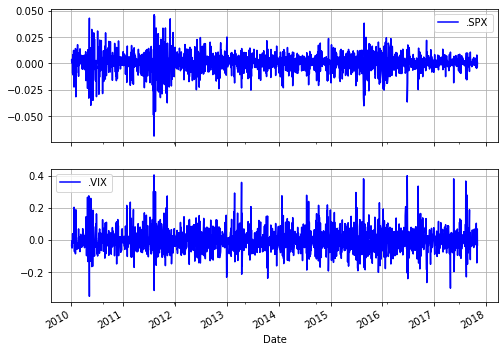

In [6]:
# 좀 더 정확한 분석을 위해 두 시계열의 로그 수익률을 구해보자
rets = np.log(data / data.shift(1)) 
print(rets.head(10))

rets.dropna(inplace=True)

rets.plot(subplots=True, grid=True, style='b', figsize=(8, 6))

# tag: es50_vs_rets
# title: Log returns of S&P500 and VIX


[-6.45336250e+00  2.34474296e-03]


Text(0, 0.5, 'VIX returns')

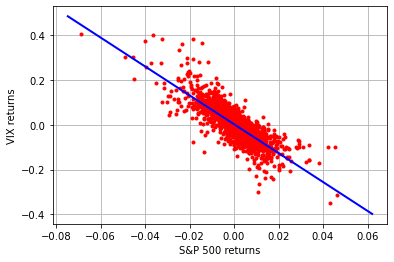

In [7]:
# 회귀분석
import matplotlib.pyplot as plt

# S&P 500지수를 독립변수로, VIX 지수를 종속변수로 한다.
xdat = rets['.SPX'].values
ydat = rets['.VIX'].values
reg = np.polyfit(x=xdat, y=ydat, deg=1)

# 분석결과 높은 수치의 음의 상관관계가 존재한다.
print(reg)

# 이 값을 로그수익률과 함께 시각화해보자. 레버리지 효과를 강력하게 지지하는 것을 알 수 있다.

# 로그 수익률의 스캐터 플롯
plt.plot(xdat, ydat, 'r.')
ax = plt.axis()  # grab axis values

x = np.linspace(ax[0], ax[1] + 0.01)
# 회귀분석선 그리기
plt.plot(x, np.polyval(reg, x), 'b', lw=2)
plt.grid(True)
plt.axis('tight')
plt.xlabel('S&P 500 returns')
plt.ylabel('VIX returns')

# tag: scatter_rets
# title: Scatter plot of log returns and regression line

.SPX      .VIX
.SPX  1.000000 -0.808372
.VIX -0.808372  1.000000


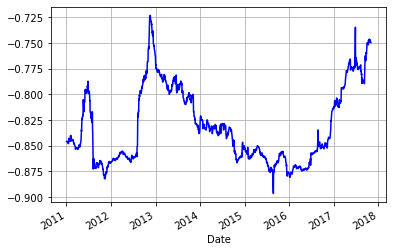

In [8]:
# 마지막 검증을 위해 두 시계열 값에서 직접 상관계수를 계산해보자

print(rets.corr())

# 상관계수 값은 큰 음의 값이긴 하지만 다음과 같이 시간에 따라 크게 변화한다. 여기에서는 상관계수를 연단위 기준으로 계산
rets['.SPX'].rolling(window=252).corr(rets['.VIX']).plot(grid=True, style='b')

# tag: roll_corr
# title: Rolling correlation between S&P 500 and VIX

In [9]:
# High Frequency Data : 고빈도 자료 다루기
# 일간 자료가 아닌 틱 데이터를 다뤄보자

import numpy as np
import pandas as pd
import datetime as dt
%matplotlib inline

# data from FXCM Forex Capital Markets Ltd.
eur_usd = pd.read_csv('./source/fxcm_eur_usd_tick_data.csv', index_col=0, parse_dates=True)
eur_usd.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17352 entries, 2017-11-10 12:00:00.007000 to 2017-11-10 14:00:00.131000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Bid     17352 non-null  float64
 1   Ask     17352 non-null  float64
dtypes: float64(2)
memory usage: 406.7 KB


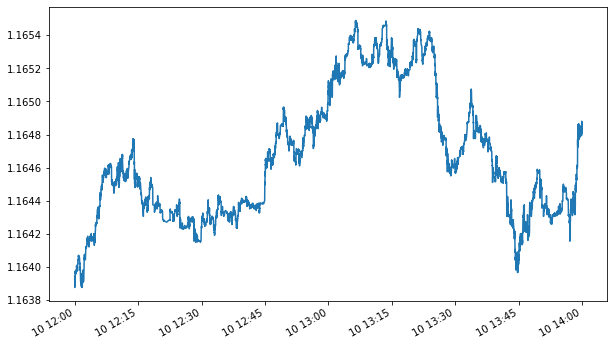

In [10]:
# 매수호가 bid와 매도호가 ask의 평균값인 mid 계산후 시각화
eur_usd['Mid'] = eur_usd.mean(axis=1)
eur_usd['Mid'].plot(figsize=(10, 6))

# tag: eur_uusd
# title: EUR/USD tick data for two hours


In [11]:
# 보통 틱 데이터의 시계열은 자료 사이의 간격이 불규칙하기 때문에 DatetiemIndex 인덱스를 사용한다.
# 그러나 작업의 성격에 따라서는 틱 데이터를 시간 간격이 일정하도록 리샘플링을 하는 것이 도움될 수 있다.
# 1분 기준으로 가장 마지막 값을 선택했다.
# 만약에 구간에 평균을 취하는 경우 매수호가열과 같은 자료에는 적합하지만, 매수호가 잔량열에는 적합하지 않을 수 있다.

eur_usd_resam = eur_usd.resample(rule='1min').last()
print(eur_usd_resam.head(10))

Bid      Ask       Mid
2017-11-10 12:00:00  1.16406  1.16407  1.164065
2017-11-10 12:01:00  1.16396  1.16397  1.163965
2017-11-10 12:02:00  1.16416  1.16418  1.164170
2017-11-10 12:03:00  1.16417  1.16417  1.164170
2017-11-10 12:04:00  1.16425  1.16427  1.164260
2017-11-10 12:05:00  1.16441  1.16442  1.164415
2017-11-10 12:06:00  1.16456  1.16457  1.164565
2017-11-10 12:07:00  1.16461  1.16462  1.164615
2017-11-10 12:08:00  1.16451  1.16452  1.164515
2017-11-10 12:09:00  1.16454  1.16455  1.164545


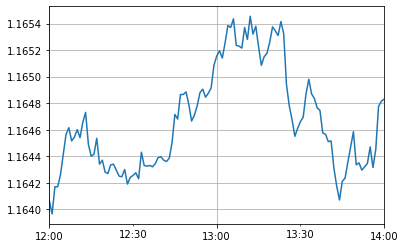

In [12]:
# 그래프를 시각화 해보면 결과가 좀 더 부드러워진 것을 볼 수 있다.
eur_usd_resam['Mid'].plot(grid=True)
# tag: eur_usd_resam
# title: Resampled EUR/USD exchange rate tick data

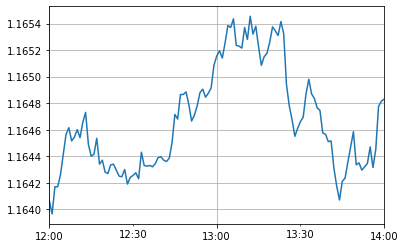

In [13]:
# 이 자료에 임의로 만든 파이썬 함수를 적용해 볼 수도 있다.

def model_arbi(x):
   return x

eur_usd_resam['Mid'].apply(model_arbi).plot(grid=True)


In [14]:
# 기존 그래프 설정 초기화
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# 그래프 설정 추가
from pylab import plt
plt.style.use('seaborn')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


Text(0, 0.5, 'f(x)')

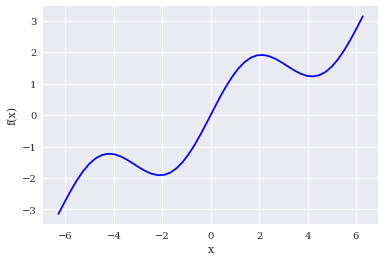

In [15]:
# 삼각함수와 선형 항의 합으로 구성된 함수

def f(x):
    return np.sin(x) + 0.5 * x

# 핵심은 이 함수를 주어진 구간에서 회귀법(regression)과 보간법(interpolation)으로 근사화하는 것이다.
# 우선 근삿값이 어떤 형태를 가져야 하는지 살펴보기 위해 그래프를 그려보자
# 관심구간을 설정하고 그래프를 그려본다.

x = np.linspace(-2 * np.pi, 2 * np.pi, 50)

plt.plot(x, f(x), 'b')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
# tag: sin_plot
# title: Example function plot
# size: 60


Text(0, 0.5, 'f(x)')

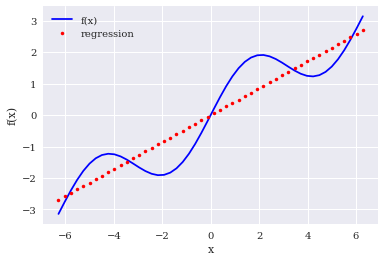

In [16]:
# 회귀법은 함수 근사의 경우 효율적인 방법으로 일차원뿐 아니라 다차원 함수의 근사도 가능하다.
# 회귀법은 기본적으로 기저함수집합과 목점함수에 따라 기저함수를 조합하기 위한 최적 파라미터를 찾는 작업이다.
# 가장 간단한 경우는 기저함수로 단항식을 사용하는 경우이다.
# numpy는 최적 파라미터를 결정하는 함수 polyfit과 주어진 입력 값에 대해 근차 값을 계산하는 함수 polyval을 가지고 있다.abs

# deg=1으로 사용하면 선형회귀가 된다.
reg = np.polyfit(x, f(x), deg=1)
ry = np.polyval(reg, x)

# 회귀 추정값이 ry배열에 저장되면 회귀 결과를 원래 함수와 비교할 수 있다.
# 당연하게도 선형 회귀를 쓰면 예제 함수 sin부분을 설명할 수 없다.
plt.plot(x, f(x), 'b', label='f(x)')
plt.plot(x, ry, 'r.', label='regression')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
# tag: sin_plot_reg_1
# title: Example function and linear regression
# size: 60


Text(0, 0.5, 'f(x)')

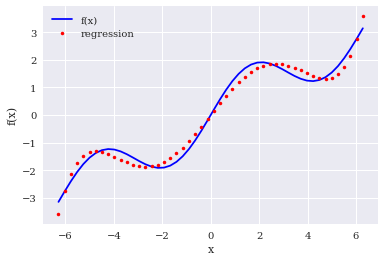

In [17]:
# 예제 함수의 sin부분을 설명하기 위해서는 고차식이 필요하다.
# 5차까지의 단항식을 기저함수로 사용해보자. 원래 함수에 더 가까운 형태가 되지만, 여전히 완벽하지는 않다.

reg = np.polyfit(x, f(x), deg=5)
ry = np.polyval(reg, x)

plt.plot(x, f(x), 'b', label='f(x)')
plt.plot(x, ry, 'r.', label='regression')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
# tag: sin_plot_reg_2
# title: Regression with monomials up to order 5
# size: 60

False
0.00177691347595176


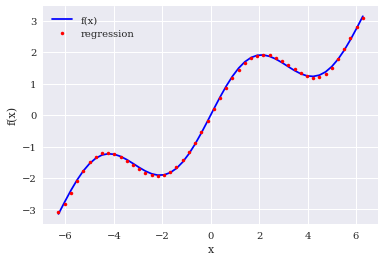

In [20]:
# 7차를 사용했다

reg = np.polyfit(x, f(x), 7)
ry = np.polyval(reg, x)

plt.plot(x, f(x), 'b', label='f(x)')
plt.plot(x, ry, 'r.', label='regression')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
# tag: sin_plot_reg_3
# title: Regression with monomials up to order 7
# size: 60

# 결과를 확인해보면 완벽하게 일치하지는 않는다
print(np.allclose(f(x), ry))

# 평균 제곱 오차 (MSE) 값이 그다지 크지 않다.
print(np.sum((f(x) - ry) ** 2) / len(x))


[ 1.16778801e-14  5.62777448e-01 -8.88178420e-16 -5.43553615e-03]


Text(0, 0.5, 'f(x)')

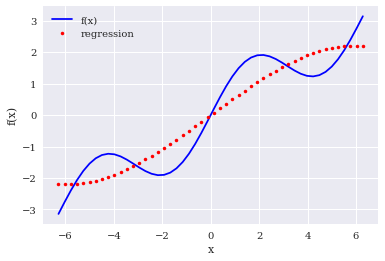

In [21]:
# 개별 기저 함수

# 일반적으로 근사화하고자 하는 함수에 대해 알고 있는 지식을 사용하여 더 적합한 기저 함수를 선택하면 회귀 결과를 향상시킬 수 있다.
# numpy를 사용한 행렬 방법으로 정의한 개별 기저 함수를 사용할 수 있다.
# 만약 단순히 기저 함수로 3차까지의 단항식을 사용한다면 기저 함수 값은 다음과 같이 행렬로 표시할 수 있다.

matrix = np.zeros((3 + 1, len(x)))
matrix[3, :] = x ** 3
matrix[2, :] = x ** 2
matrix[1, :] = x
matrix[0, :] = 1

# numpy는 최소 자승 최적화 문제를 위한 lstsq 함수를 제공한다.
reg = np.linalg.lstsq(matrix.T, f(x))[0]
print(reg)

# 회귀 결과를 구하려면 reg와 matrix 배열에 대해 dot 함수를 적용하면 된다. 
ry = np.dot(reg, matrix)

plt.plot(x, f(x), 'b', label='f(x)')
plt.plot(x, ry, 'r.', label='regression')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
# tag: sin_plot_reg_4
# title: Regression via least-squares function
# size: 60

True
9.01766622280769e-31
[4.36463437e-16 5.00000000e-01 0.00000000e+00 1.00000000e+00]


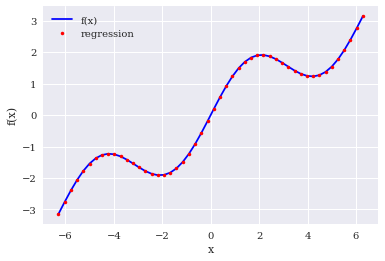

In [23]:
# 단항식을 이용한 이전 결과에 비해 그다지 나아지지 않았다
# 우리는 함수에 sin이 포함되어 있는 것을 알고 있기 때문에 기저 함수 집합에 사인 함수를 포함할 수 있다.
# 기저 함수 중 가장 고차 단항식을 사인 함수로 바꿔보자

matrix[3, :] = np.sin(x)
reg = np.linalg.lstsq(matrix.T, f(x))[0]
ry = np.dot(reg, matrix)

plt.plot(x, f(x), 'b', label='f(x)')
plt.plot(x, ry, 'r.', label='regression')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
# tag: sin_plot_reg_5
# title: Regression using individual functions
# size: 60

print(np.allclose(f(x), ry))

print(np.sum((f(x) - ry) ** 2) / len(x))

print(reg)

Text(0, 0.5, 'f(x)')

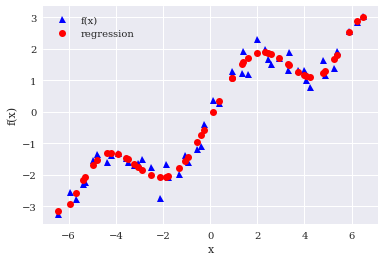

In [24]:
# 잡음이 있는 자료

# 회귀법은 시뮬레이션뿐 아니라 부정확한 측정으로 얻은 자료에도 적용할 수 있다.
# 독립변수와 측정값에 잡음이 있는 자료를 생성해보자


xn = np.linspace(-2 * np.pi, 2 * np.pi, 50)
xn = xn + 0.15 * np.random.standard_normal(len(xn))
yn = f(xn) + 0.25 * np.random.standard_normal(len(xn))

# 회귀계산
reg = np.polyfit(xn, yn, 7)
ry = np.polyval(reg, xn)

# 회귀 결과를 보면 잡음이 있는 자료보다는 원래 함수에 더 가까운 형태임을 알 수 있다. 즉 회귀법은 어느 정도 잡음을 소거하는 특징을 가진다.
plt.plot(xn, yn, 'b^', label='f(x)')
plt.plot(xn, ry, 'ro', label='regression')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
# tag: sin_plot_reg_6
# title: Regression with noisy data
# size: 60


[ 1.52 -2.25  5.8  -0.67 -3.35  3.02  2.15 -4.94  0.46  2.17]
[ 1.76 -1.9   2.43 -0.96 -1.47  1.63  1.91 -1.49  0.68  1.91]


Text(0, 0.5, 'f(x)')

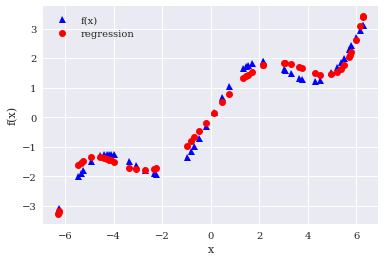

In [25]:
# 정렬되지 않은 자료

# 회귀법의 또 다른 특성은 정렬되지 않은 자료에도 적용할 수 있다는 점이다.
# 정렬되지 않은 독립변수를 생성해보자

xu = np.random.rand(50) * 4 * np.pi - 2 * np.pi
yu = f(xu)

print(xu[:10].round(2))
print(yu[:10].round(2))

# 잡음이 있는 자료와 마찬가지로 회귀 방법은 관측점의 순서에 영향을 받지 않는다.

reg = np.polyfit(xu, yu, 5)
ry = np.polyval(reg, xu)

plt.plot(xu, yu, 'b^', label='f(x)')
plt.plot(xu, ry, 'ro', label='regression')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
# tag: sin_plot_reg_7
# title: Regression with unsorted data
# size: 60

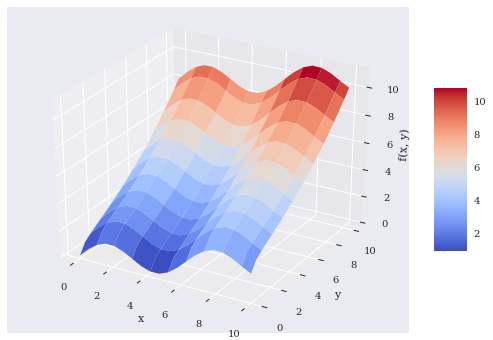

In [26]:
# 다차원 자료

# 최소 자승 회귀법의 또 하나의 장점은 별다른 수정 없이 다차원 자료에도 쓸 수 있다는 점이다.
# 예제로 함수를 하나 정의해보자


def fm(p):
    x, y = p
    return np.sin(x) + 0.25 * x + np.sqrt(y) + 0.05 * y ** 2

# 이 함수를 시각화하려면 독립 변수의 그리드(grid)가 필요하다.

x = np.linspace(0, 10, 20)
y = np.linspace(0, 10, 20)
X, Y = np.meshgrid(x, y)
  # generates 2-d grids out of the 1-d arrays
Z = fm((X, Y))
x = X.flatten()
y = Y.flatten()
  # yields 1-d arrays from the 2-d grids

from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=2, cstride=2, cmap=mpl.cm.coolwarm,
        linewidth=0.5, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
fig.colorbar(surf, shrink=0.5, aspect=5)
# tag: sin_plot_3d_1
# title: Function with two parameters
# size: 60

In [27]:
# 잘 된 회귀 결과를 얻기 위해 우리가 예제 함수에 대해 알고 있는 정보를 사용하여 사인함수와 제곱근 함수를 포함하는 기저함수집합을 만든다

matrix = np.zeros((len(x), 6 + 1))
matrix[:, 6] = np.sqrt(y)
matrix[:, 5] = np.sin(x)
matrix[:, 4] = y ** 2
matrix[:, 3] = x ** 2
matrix[:, 2] = y
matrix[:, 1] = x
matrix[:, 0] = 1

# 일차원과 다차원에서 모두 사용 가능한 일반적인 최소 자승 회귀 계산을 위한 함수인 OLS 제공
import statsmodels.api as sm

# OLS 함수의 장점은 회귀 계산과 그 특성에 대한 다양한 추가 정보를 제공한다는 점
model = sm.OLS(fm((x, y)), matrix).fit()

print(model.rsquared)
print(model.params)

1.0
[ 1.54043445e-15  2.50000000e-01  3.05119054e-15 -6.07153217e-17
  5.00000000e-02  1.00000000e+00  1.00000000e+00]


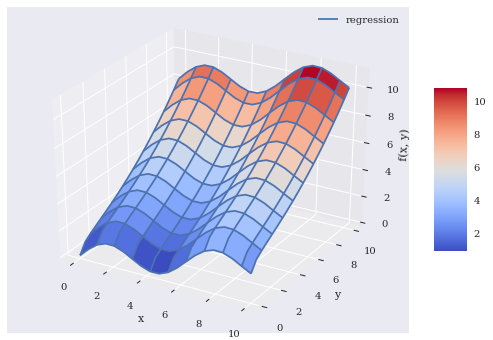

In [29]:
# 최적 회귀 계수와 독립 변수 좌표가 주어지면 회귀 함수의 값을 계산하는 함수 생성

def reg_func(a, p):
    x, y = p
    f6 = a[6] * np.sqrt(y)
    f5 = a[5] * np.sin(x)
    f4 = a[4] * y ** 2
    f3 = a[3] * x ** 2
    f2 = a[2] * y
    f1 = a[1] * x
    f0 = a[0] * 1
    return (f6 + f5 + f4 + f3 +
            f2 + f1 + f0)

RZ = reg_func(model.params, (X, Y))

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
surf1 = ax.plot_surface(X, Y, Z, rstride=2, cstride=2,
            cmap=mpl.cm.coolwarm, linewidth=0.5,
            antialiased=True)
surf2 = ax.plot_wireframe(X, Y, RZ, rstride=2, cstride=2,
                          label='regression')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.legend()
fig.colorbar(surf, shrink=0.5, aspect=5)
# tag: sin_plot_3d_2
# title: Higher dimension regression
# size: 60

True


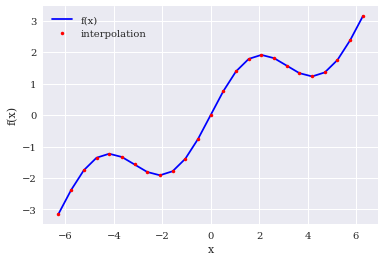

In [31]:
# 보간법

# 회귀법과 달리 보간법은 수학적으로 훨씬 더 복잡하고 다차원에 적용하기 어렵다.
# 보간법은 x차원의 정렬된 관측점이 주어졌을 때 두 개의 이웃하는 관측점 사이의 자료를 계산하는 보간 함수를 만드는 것이다.

# 보간 함수는 관측점 자체도 정확하게 재현해야 하고 각 관측점에서 연속 미분 가능한 함수 이어야 한다.
# 연속 미분 가능하기 위해서는 보간 함수가 최소 3차 이상, 즉 큐빅 스플라인 함수이어야 한다.

import scipy.interpolate as spi

x = np.linspace(-2 * np.pi, 2 * np.pi, 25)


def f(x):
    return np.sin(x) + 0.5 * x

# 보간 방법은 x축 방향으로 정렬된 자료를 사용한다는 점만 빼면 회귀 방법과 유사하다.
# 다만 여기에서는 polyfit과 polyval 함수 대신 splrep와 splev 함수를 각각 사용한다.
ipo = spi.splrep(x, f(x), k=1)
iy = spi.splev(x, ipo)

# 1차 스플라인 보간법만 사용해도 성능이 괜찮아보인다.
plt.plot(x, f(x), 'b', label='f(x)')
plt.plot(x, iy, 'r.', label='interpolation')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
# tag: sin_plot_ipo_1
# title: Example plot with linear interpolation
# size: 60

# 수치적으로 확인
print(np.allclose(f(x), iy))


Text(0, 0.5, 'f(x)')

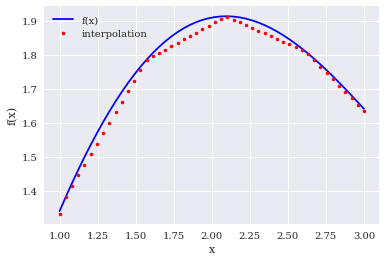

In [32]:
# 스플라인 보간법은 금융 분야에서 독립 변수 값을 관측할 수 없을 경우의 종속 변수 값을 추정할 때 종종 사용된다.
# 더 작은 구간에서 선형 스플라인을 사용하였을 경우에 보간된 값을 자세히 보자

xd = np.linspace(1.0, 3.0, 50)
iyd = spi.splev(xd, ipo)

# 응용 분야에 따라서는 이 정도의 정확도로 부족할 수 있다. 또 보간된 함수가 관측점 위치에서 연속 미분이 아니라는 점도 명확하다
plt.plot(xd, f(xd), 'b', label='f(x)')
plt.plot(xd, iyd, 'r.', label='interpolation')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
# tag: sin_plot_ipo_2
# title: Example plot (detail) with linear interpolation
# size: 60



False
1.1349319851436252e-08


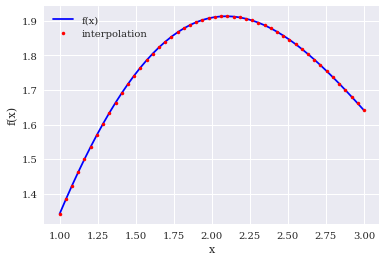

In [33]:
# 이번에는 3차 큐빅 스플라인을 사용하여 예제를 풀어보자

ipo = spi.splrep(x, f(x), k=3)
iyd = spi.splev(xd, ipo)

plt.plot(xd, f(xd), 'b', label='f(x)')
plt.plot(xd, iyd, 'r.', label='interpolation')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
# tag: sin_plot_ipo_3
# title: Example plot (detail) with cubic splines interpolation
# size: 60

# 수치적으로는 보간이 완벽하지 않지만 최소 자승 오차는 작다.
print(np.allclose(f(xd), iyd))
print(np.sum((f(xd) - iyd) ** 2) / len(xd))

# 스플라인 보간법을 적용하면 최소 자승 회귀법보다 더 정확한 근사 결과를 얻을 수 있다.
# 그러나 보간법을 사용하려면 자료가 정렬되어 있어야 하고 잡음이 없어야 하며 다차원 문제에서는 적용할 수 없다.
# 또한 계산량이 더 많기 때문에 어떤 경우에는 회귀법보다 훨씬 계산 시간이 오래 걸릴 수 있다.



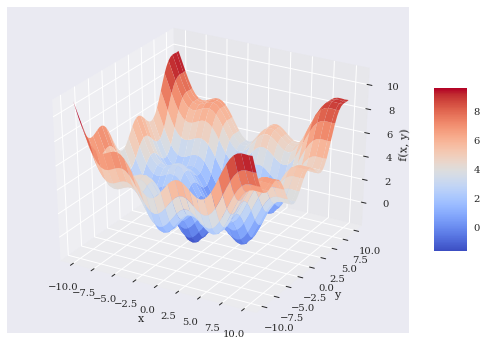

In [34]:
# 최적화
# 금융이나 경제 분야에서는 최적화가 중요한 역할을 한다.
# 예로 옵션 가격 계산을 위해서 시장 자료를 기반으로 인수 교정(calibration) 하거나 대리인의 효용 함수를 최적화하는 경우 등이다.
# 우리가 최소화하고자 하는 함수의 예로 다음과 같이 정의된 함수 fm이 있다고 하자

def fm(p):
    x, y = p
    return (np.sin(x) + 0.05 * x ** 2
          + np.sin(y) + 0.05 * y ** 2)

x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)
X, Y = np.meshgrid(x, y)
Z = fm((X, Y))

# 주어진 함수를 시각화해보면 여러 개의 국소 최소점을 가지고 있다는 것을 알 수 있다.
# 이 그림만으로는 전역 최소점이 존재하는지 알기 힘들다

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=2, cstride=2, cmap=mpl.cm.coolwarm,
        linewidth=0.5, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
fig.colorbar(surf, shrink=0.5, aspect=5)
# tag: opt_plot_3d
# title: Function to minimize with two parameters
# size: 60

In [36]:
# 전역 최소화 방법과 국소 최소화 방법을 구현해보자

# 전역 최적화

# 최적화 과정을 수행할 때 일어나는 일들을 더 자세히 살펴보기 위해 인수 값과 함수 값을 출력하도록 원래의 함수를 고친다.

import scipy.optimize as spo

def fo(p):
    x, y = p
    z = np.sin(x) + 0.05 * x ** 2 + np.sin(y) + 0.05 * y ** 2
    if output == True:
        print('%8.4f %8.4f %8.4f' % (x, y, z))
    return z

# 이제 최적화 과정에서 발생하는 일들을 추적할 수 있게 되었다.
# brute 함수는 범위를 입력으로 받는다. 예를 들어 x값 인수 범위를 (-10, 10.1, 5)로 주면 brute 함수는 x 값에 -10, -5, 0, 5, 10을 주고 함수를 테스트해본다.

output = True
spo.brute(fo, ((-10, 10.1, 5), (-10, 10.1, 5)), finish=None)

-10.0000 -10.0000  11.0880
-10.0000 -10.0000  11.0880
-10.0000  -5.0000   7.7529
-10.0000   0.0000   5.5440
-10.0000   5.0000   5.8351
-10.0000  10.0000  10.0000
 -5.0000 -10.0000   7.7529
 -5.0000  -5.0000   4.4178
 -5.0000   0.0000   2.2089
 -5.0000   5.0000   2.5000
 -5.0000  10.0000   6.6649
  0.0000 -10.0000   5.5440
  0.0000  -5.0000   2.2089
  0.0000   0.0000   0.0000
  0.0000   5.0000   0.2911
  0.0000  10.0000   4.4560
  5.0000 -10.0000   5.8351
  5.0000  -5.0000   2.5000
  5.0000   0.0000   0.2911
  5.0000   5.0000   0.5822
  5.0000  10.0000   4.7471
 10.0000 -10.0000  10.0000
 10.0000  -5.0000   6.6649
 10.0000   0.0000   4.4560
 10.0000   5.0000   4.7471
 10.0000  10.0000   8.9120


array([0., 0.])

In [37]:
# 결과를 보면 최적 인수 값은 x=y=0 이고 이때의 함수 값은 0이다.
# 여기에서는 각 인수값에 대한 조사 간격을 5로 느슨하게 사용하였다.
# 이 값을 조정하면 더 자세히 조사할 수 있다.

output = False
opt1 = spo.brute(fo, ((-10, 10.1, 0.1), (-10, 10.1, 0.1)), finish=None)
print(opt1)
print(fm(opt1))

# 최적 인수 값은 x=y=-1.4
# 전역 최소화 지점에서의 함수 값은 -1.7749

[-1.4 -1.4]
-1.7748994599769203


In [38]:
# 함수 fmin은 최소화하려는 함수와 시작 인수 값을 입력으로 받는다. 
# 추가적으로 인수나 함수 값의 허용오차 수준을 정의하거나 반복 계산 최대 횟수를 정할 수도 있다.

output = True
opt2 = spo.fmin(fo, opt1, xtol=0.001, ftol=0.001, maxiter=15, maxfun=20)
print(opt2)
print(fm(opt2))

# 최적 인수의 값이 좀 더 정확해지고 최소 함수 값이 더 낮아졌음을 확인할 수 있다.

-1.4000  -1.4000  -1.7749
 -1.4700  -1.4000  -1.7743
 -1.4000  -1.4700  -1.7743
 -1.3300  -1.4700  -1.7696
 -1.4350  -1.4175  -1.7756
 -1.4350  -1.3475  -1.7722
 -1.4088  -1.4394  -1.7755
 -1.4438  -1.4569  -1.7751
 -1.4328  -1.4427  -1.7756
 -1.4591  -1.4208  -1.7752
 -1.4213  -1.4347  -1.7757
 -1.4235  -1.4096  -1.7755
 -1.4305  -1.4344  -1.7757
 -1.4168  -1.4516  -1.7753
 -1.4305  -1.4260  -1.7757
 -1.4396  -1.4257  -1.7756
 -1.4259  -1.4325  -1.7757
 -1.4259  -1.4241  -1.7757
 -1.4304  -1.4177  -1.7757
 -1.4270  -1.4288  -1.7757
[-1.42702972 -1.42876755]


In [39]:
# 대부분의 최적화 문제에서 국소 최솟값을 구하기 전에 전역 최소화를 할 것을 권장한다.
# 이유는 국소 최소화 알고리즘이 일단 어떤 국소 최저점에 빠져버리게 되면 더 나은 국소 최솟값이나 전역최솟값을 찾아내지 못하기 때문이다.
# 다음은 시작 인수 값을 x=y=2 로 하는 경우에 찾아낸 최솟값이 0보다 커지는 것을 보여준다.

output = False
spo.fmin(fo, (2.0, 2.0), maxiter=250)

Optimization terminated successfully.
         Current function value: 0.015826
         Iterations: 46
         Function evaluations: 86


array([4.2710728 , 4.27106945])

In [40]:
# 제약 조건이 있는 최적화

# 지금까지는 제약 조건이 없는 최적화 문제를 고려하였다. 그러나 경제 혹은 금융 관련 최적화 문제는 한 개 이상의 제약 조건을 가지는 경우가 많다.
# 이러한 제약 조건들은 등식이나 부등식의 형태로 주어진다.

# 두 개의 위험 주식에 투자하는 투자자의 기대 효용함수를 최대화하는 효용함수 최대화 문제를 생각해보자.

# function to be minimized
from math import sqrt

def Eu(p):
    s, b = p
    return -(0.5 * sqrt(s * 15 + b * 5) + 0.5 * sqrt(s * 5 + b * 12))

# constraints
cons = ({'type': 'ineq', 'fun': lambda p: 100 - p[0] * 10 - p[1] * 10})
  # budget constraint
bnds = ((0, 1000), (0, 1000))  # uppper bounds large enough

result = spo.minimize(Eu, [5, 5], method='SLSQP',
                       bounds=bnds, constraints=cons)
# 최적 객체
print(result)

# 최적 인수 값
print(result['x'])

# 최적 함수 값
print(-result['fun'])

# 최적 주식 수와 가격 벡터를 내적하면 예산 구할 수 있음
print(np.dot(result['x'], [10, 10]))

fun: -9.700883611487832
     jac: array([-0.48508096, -0.48489535])
 message: 'Optimization terminated successfully.'
    nfev: 21
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([8.02547122, 1.97452878])


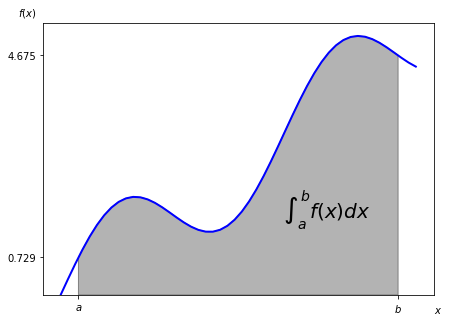

In [4]:
# 일반적인 가치 계산이나 옵션 가격 계산에서 적분은 중요한 수학 도구이다. 
# 파생상품의 위험 중립 가치는 일반적으로 위험 중립 척도 하에서 최종 가치를 할인한 값의 기댓값으로 표현된다.
# 기댓값은 이산 확률 문자에서는 합계로 계산하고 연속 확률 문제에서는 적분 문제가 된다.
# scipy.integrate 라이브러리는 여러 가지 수치적분 계산을 위한 여러 가지 함수를 제공한다.
import scipy.integrate as sci
import numpy as np

def f(x):
    return np.sin(x) + 0.5 * x

a = 0.5  # left integral limit
b = 9.5  # right integral limit
x = np.linspace(0, 10)
y = f(x)

# 시각화
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(x, y, 'b', linewidth=2)
plt.ylim(ymin=0)

# area under the function
# between lower and upper limit
Ix = np.linspace(a, b)
Iy = f(Ix)
verts = [(a, 0)] + list(zip(Ix, Iy)) + [(b, 0)]
poly = Polygon(verts, facecolor='0.7', edgecolor='0.5')
ax.add_patch(poly)

# labels
plt.text(0.75 * (a + b), 1.5, r"$\int_a^b f(x)dx$",
         horizontalalignment='center', fontsize=20)

plt.figtext(0.9, 0.075, '$x$')
plt.figtext(0.075, 0.9, '$f(x)$')

ax.set_xticks((a, b))
ax.set_xticklabels(('$a$', '$b$'))
ax.set_yticks([f(a), f(b)])
# tag: sin_integral
# title: Example function with integral area
# size: 50

In [6]:
# 수치 적분

# integrate 라이브러리는 주어진 수학 함수를 구간 내에서 수치적으로 정적분하기 위한 다양한 함수를 가지고 있다.
# fixed_quad 함수는 가우스 구적법을, quad 함수는 적응 구적법을, romberg 함수는 롬베르크 적분법을 사용하여 정적분 값을 계산한다.

print(sci.fixed_quad(f, a, b)[0])
print(sci.quad(f, a, b)[0])
print(sci.romberg(f, a, b))

# list나 ndarray 객체를 통해 함수 값을 입력으로 받는 정적분 함수도 있다. 
# 예를 들어 사다리꼴법을 사용하는 trapz함수, 심슨 방법을 사용하는 simps 함수 등이다.
xi = np.linspace(0.5, 9.5, 25)
print(sci.trapz(f(xi), xi))
print(sci.simps(f(xi), xi))


24.366995967084602
24.374754718086752
24.374754718086713
24.352733271544516
24.37496418455075


In [7]:
# 시뮬레이션을 사용한 적분 계산

# 몬테카를로 시뮬레이션으로 옵션과 파생상품의 가치를 평가하는 것은 시뮬레이션으로 정적분을 계산할 수 있기 때문이다.
# 정적분 구간 사이에 있는 임의의 x 값들을 생성하여 이 값들에 대해 함수 값을 계산하고 이들의 평균값을 구하면 
# 내면 적분 구간에 대한 함수의 평균값을 구한 것과 같다.
# 이 평균값을 적분 구간의 길이와 곱하여 적분 구간에 대한 정적분 값을 추정한다.

# 몬테카를로 시뮬레이션에서 사용한 난수 x 값의 개수가 증가할수록 
# 몬테카를로 시뮬레이션으로 추정한 적분값이 실제 적분값으로 수렴하는 것을 보이자
# 사실 난수의 개수가 그리 크지 않아도 추정치는 충분히 정답에 가까워진다.


for i in range(1, 20):
    np.random.seed(1000)
    x = np.random.random(i * 10) * (b - a) + a
    print(np.sum(f(x)) / len(x) * (b - a))

24.804762279331463
26.522918898332378
26.265547519223976
26.02770339943824
24.99954181440844
23.881810141621663
23.527912274843253
23.507857658961207
23.67236746066989
23.679410416062886
24.424401707879305
24.239005346819056
24.115396924962802
24.424191987566726
23.924933080533783
24.19484212027875
24.117348378249833
24.100690929662274
23.76905109847816


In [9]:
# 심볼릭 연산
# 금융공학의 다양한 분야에 응용이 가능한 심볼릭 연산이다.

# SymPy는 몇 가지 새로운 객체 클래스를 도입한다. 가장 기본적인 클래스는 Symbol 클래스다

import sympy as sy

x = sy.Symbol('x')
y = sy.Symbol('y')
print(type(x))

# x가 특정한 수치 값은 없지만 Symbol 객체이기 때문에 SymPy를 쓰면 x의 제곱근을 정의할 수 있다.
print(3+sy.sqrt(x)-4**2)

# 같은 방법으로 Symbol 객체를 사용하여 임의의 함수도 정의할 수 있다.
f = x ** 2 + 3 + 0.5 * x ** 2 + 3 / 2
print(sy.simplify(f))

<class 'sympy.core.symbol.Symbol'>
sqrt(x) - 13
1.5*x**2 + 4.5


In [11]:
# SymPy는 수학식을 세 가지 형태로 표현한다.
# - 레이텍 기반
# - 유니코드 기반
# - 아스키 기반

sy.init_printing(pretty_print=False, use_unicode=False)
print(sy.pretty(f))
# 제곱이 좀 이상하게 출력되는뎅?

print(sy.pretty(sy.sqrt(x) + 0.5))
# 루트는 괜찮네

2      
1.5*x  + 4.5
  ___      
\/ x  + 0.5


In [13]:
# 파이를 수치적으로 계산할 수도 있다.
pi_str = str(sy.N(sy.pi, 400000))

# 400,000중 40자리 표시
print(pi_str[:40])

# 400,000중 마지막 40자리 표시
print(pi_str[-40:])

# 내 생일이 껴있을까?
print(pi_str.find('19950411'))

3.14159265358979323846264338327950288419
8245672736856312185020980470362464176199
-1


In [14]:
# SymPy의 장점은 방정식을 풀 수 있다는 점이다.

print(sy.solve(x ** 2 - 1))
print(sy.solve(x ** 2 - 1 - 3))
print(sy.solve(x ** 3 + 0.5 * x ** 2 - 1))
print(sy.solve(x ** 2 + y ** 2))


[-1, 1]
[-2, 2]
[0.858094329496553, -0.679047164748276 - 0.839206763026694*I, -0.679047164748276 + 0.839206763026694*I]
[{x: -I*y}, {x: I*y}]


In [15]:
# SymPy의 또 다른 장점은 적분과 미분이 가능하다는 점이다.
# 수치 적분과 시뮬레이션 적분에서 사용한 예제 함수를 다시 사용하여 이번에는 심볼릭연산 결과와 수치적으로 정확한 값을 유도한다.

a, b = sy.symbols('a b')
print(sy.pretty(sy.Integral(sy.sin(x) + 0.5 * x, (x, a, b))))

int_func = sy.integrate(sy.sin(x) + 0.5 * x, x)
print(sy.pretty(int_func))


b                    
  /                    
 |                     
 |  (0.5*x + sin(x)) dx
 |                     
/                      
a                      
      2         
0.25*x  - cos(x)


In [16]:
# 부정적분 함수를 알면 정적분의 수치 값은 세 단계로 구할 수 있다.
# SymPy 표현식으로 수치 계산을 하고자 할 때는 subs 메서드로 해당하는 심볼에 대한 값을 대입한 후 반환된 새 표현식에 대해 evalf 메서드를 호출한다.

Fb = int_func.subs(x, 9.5).evalf()
Fa = int_func.subs(x, 0.5).evalf()

# Fb와 Fa의 차이가 정확한 적분값
print(Fb-Fa)

# 심볼릭 정적분을 사용하여 품
int_func_limits = sy.integrate(sy.sin(x) + 0.5 * x, (x, a, b))
print(sy.pretty(int_func_limits))

# 다음으로 아까와 같이 수치 대입을 한다.
# 이번에는 사전 객체를 사용하여 복수의 심볼을 대입한다.
# 대입 후 값을 계산하면 적분값을 반환한다.
print(int_func_limits.subs({a : 0.5, b : 9.5}).evalf())

# 마지막으로 적분 시 적분 구간을 인수로 주어 한 번에 적분값을 구할 수도 있다.
print(sy.integrate(sy.sin(x) + 0.5 * x, (x, 0.5, 9.5)))

24.3747547180867
        2         2                  
- 0.25*a  + 0.25*b  + cos(a) - cos(b)
24.3747547180868
24.3747547180867


In [17]:
# 미분

# 부정적분 함수를 다시 미분하면 원래의 함수가 된다.
# 심볼릭 부정적분으로 구한 결과에 diff 함수를 적용하여 이를 확인해보자

print(int_func.diff())
# 미분을 사용하여 이전에 살펴본 최적화 문제의 정확한 해를 유도하고자 한다. 이를 위해 해당 함수를 다음과 같이 심볼릭 정의한다.
f = (sy.sin(x) + 0.05 * x ** 2
   + sy.sin(y) + 0.05 * y ** 2)

# 최적화 문제를 풀기 위해서는 두 변수 x,y 에 대한 두 개의 편미분이 필요하다
del_x = sy.diff(f, x)
del_y = sy.diff(f, y)

print(del_x)
print(del_y)

0.5*x + sin(x)
0.1*x + cos(x)
0.1*y + cos(y)


In [18]:
# 전역 최소화를 위한 필요 충분조건은 두 개의 편미분 값이 모두 0이 되어야 한다는 것.
# 알고리즘 상으로나 수학 원리 상으로 모두 심볼릭 해가 존재한다는 보장은 없다
# 그러나 이전에 최적호 문제에서 나온 결과를 시작점으로 이용하여 두 방정식을 수치적으로 풀 수는 있다.

xo = sy.nsolve(del_x, -1.5)
yo = sy.nsolve(del_y, -1.5)

print(xo)
print(yo)

print(f.subs({x : xo, y : yo}).evalf()) # global minimum

# 이러한 값을 이용하지 않고 임의의 값을 시작점으로 사용하면 전역 최소점이 아닌 국소 최소점에 빠질 수도 있다.

xo = sy.nsolve(del_x, 1.5)
yo = sy.nsolve(del_y, 1.5)

print(xo)
print(yo)

print(f.subs({x : xo, y : yo}).evalf()) # local minimum

# 이 결과는 편미분 값이 0인 조건이 필요조건이지만 충분조건은 아님을 보여준다.

# 파이썬으로 수학을 풀이할 때는 항상 SymPy를 사용한 심볼릭 계산을 염두에 두어야 한다.
# 특히 상호대화식 금융 분석 시에는 심볼릭 계산이 훨씬 효율적인 방식일 수 있다.

# 함수 근사는 이자율 곡선 보간이라든가 아메리칸 옵션 가치 계산을 위한 회귀 기반 몬테카를로 분석 등의 여러 가지 금융분야에서 중요하다.
# 최적화 기법도 금융 분야에서 자주 사용된다.
# 예를 들면 옵션 가격 계산 모형의 인자들을 시장 호가나 내재 변동성에 맞추는 경우 최적화가 사용된다.

# 수치 적분은 옵션 및 파생상품의 가격 계산시 빠질 수 없는 요소이다.
# 옵션 가치 계산은 확률 프로세스의 위험 중립 확률 측도를 구한 다음에는 
# 단순히 옵션의 최종 가치를 그 확률 척도 하에 현재가로 할인하여 기대치를 구하는 것일 뿐이기 때문이다.
# 앞으로는 몇 가지 유형의 확률 프로세스를 위험 중립 척도에서 시뮬레이션하는 것을 다뤄보자

# SymPy를 사용한 심볼릭 연산은 적분, 미분, 방정식과 같은 다양한 수학 연산에서 아주 유용하고 효율적인 도구가 될 수 있다.

-1.42755177876459
-1.42755177876459
-1.77572565314742
1.74632928225285
1.74632928225285
2.27423381055640
